In [1]:
import os, tf2onnx, time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras

#from dtaidistance import dtw_visualisation as dtwvis
from utils.crane_dataset import CraneDataset
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import RobustScaler
#from dtaidistance import dtw
from tqdm.notebook import tqdm

In [2]:
train_data_file_path_list = []
train_data_file_name_list = ['safe-boom-40-swing-180-load-40-.csv', 'safe-boom-60-swing-180-load-60-.csv',
                             'safe-boom-70-swing-180-load-100-.csv', 'safe-boom-80-swing-180-load-120-.csv',
                             'unsafe-swing-0-load-70-.csv', 'unsafe-swing-0-load-90-.csv',
                             'unsafe-swing-45-load-70-.csv', 'unsafe-swing-90-load-90-.csv',
                             'unsafe-swing-135-load-50-.csv', 'unsafe-swing-135-load-70-.csv',
                             'unsafe-swing-180-load-70-.csv', 'unsafe-swing-180-load-90-.csv']

# train_data_file_path_list = ['unsafe-swing-0-load-70-.csv', 'unsafe-swing-0-load-90-.csv',
#                              'unsafe-swing-45-load-50-.csv', 'unsafe-swing-45-load-70-.csv',
#                              'unsafe-swing-90-load-70-.csv', 'unsafe-swing-90-load-90-.csv',
#                              'unsafe-swing-135-load-50-.csv', 'unsafe-swing-135-load-70-.csv']
# 
for i, file_name in enumerate(train_data_file_name_list):
    train_data_file_path_list.append(os.path.join('data', file_name))

In [3]:
val_data_file_path_list = []
val_data_file_name_list = ['safe-boom-50-swing-180-load-50-.csv', 'unsafe-swing-45-load-50-.csv', 'unsafe-swing-90-load-70-.csv',]
# val_data_file_path_list = ['unsafe-swing-180-load-70-.csv', 'unsafe-swing-180-load-90-.csv']

for i, file_name in enumerate(val_data_file_name_list):
    val_data_file_path_list.append(os.path.join('data', file_name))

#### load dataset

In [4]:
train_dataset_inst = CraneDataset(train_data_file_path_list)
val_dataset_inst = CraneDataset(val_data_file_path_list)

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
raw_train_dataset = train_dataset_inst.get_dataset()
raw_val_dataset = val_dataset_inst.get_dataset()

In [6]:
for file_path in train_data_file_path_list:
    file_name = os.path.basename(file_path)
    train_data = raw_train_dataset[file_name][train_dataset_inst.get_data_feature_names()+train_dataset_inst.get_data_target_names()]
    train_data = train_data.to_numpy()
    raw_train_dataset[file_name] = train_data[::10]

In [7]:
for file_path in val_data_file_path_list:
    file_name = os.path.basename(file_path)
    val_data = raw_val_dataset[file_name][val_dataset_inst.get_data_feature_names()+val_dataset_inst.get_data_target_names()]
    val_data = val_data.to_numpy()
    raw_val_dataset[file_name] = val_data[::10]

#### display for raw data(train, validation)

Text(0, 0.5, 'value')

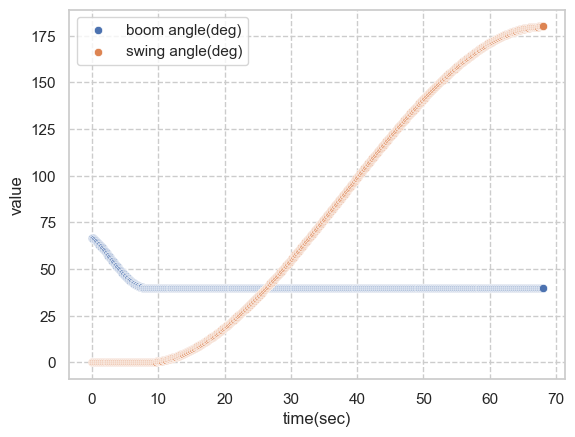

In [8]:
file_name_index = 0
file_name = os.path.basename(train_data_file_path_list[file_name_index])
time_arr = np.arange(0, (raw_train_dataset[file_name].shape[file_name_index])*0.1, 0.1)

sns.set(font_scale=1.0)
sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.scatterplot(x=time_arr, y=raw_train_dataset[file_name][:, 0], label='boom angle(deg)')
sns.scatterplot(x=time_arr, y=raw_train_dataset[file_name][:, 1], label='swing angle(deg)')

plt.grid(True)
plt.xlabel('time(sec)')
plt.ylabel('value')

Text(0, 0.5, 'Load(N)')

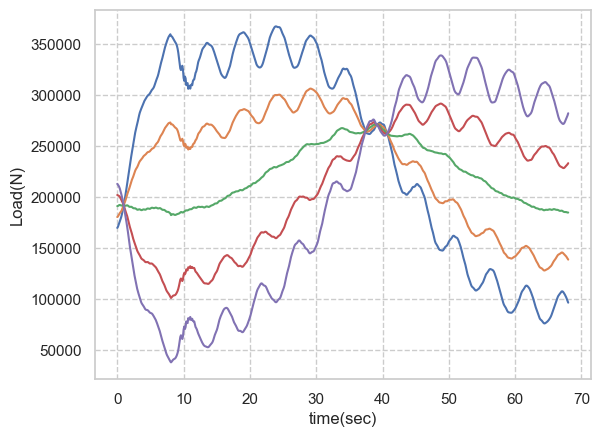

In [9]:
file_name_index = 0
file_name = os.path.basename(train_data_file_path_list[file_name_index])
time_arr = np.arange(0, (raw_train_dataset[file_name].shape[file_name_index])*0.1, 0.1)

sns.set_style("whitegrid", {'grid.linestyle': '--'})

for i in range(5):
    sns.lineplot(x=time_arr, y=raw_train_dataset[file_name][:, 3+i]) 

plt.xlabel('time(sec)')
plt.ylabel('Load(N)')

Text(0, 0.5, 'Load(N)')

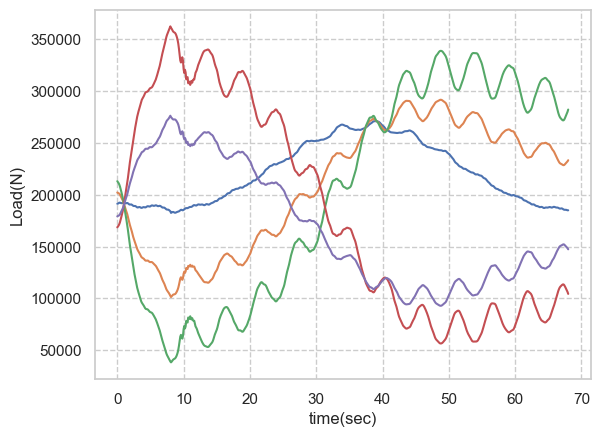

In [10]:
file_name_index = 0
file_name = os.path.basename(train_data_file_path_list[file_name_index])
time_arr = np.arange(0, (raw_train_dataset[file_name].shape[file_name_index])*0.1, 0.1)

sns.set_style("whitegrid", {'grid.linestyle': '--'})

for i in range(5):
    sns.lineplot(x=time_arr, y=raw_train_dataset[file_name][:, 5+i]) 

plt.xlabel('time(sec)')
plt.ylabel('Load(N)')

Text(0.5, 0, 'angle(deg)')

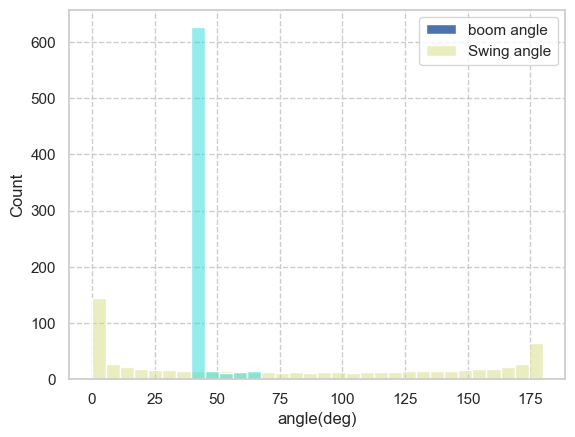

In [11]:
file_name_index = 0
file_name = os.path.basename(train_data_file_path_list[file_name_index])
sns.histplot(raw_train_dataset[file_name][:, 0:2], palette='rainbow')
plt.legend(['boom angle', 'Swing angle'])
#plt.xlim(-100, 200)
plt.xlabel('angle(deg)')

Text(0.5, 0, 'Load(N)')

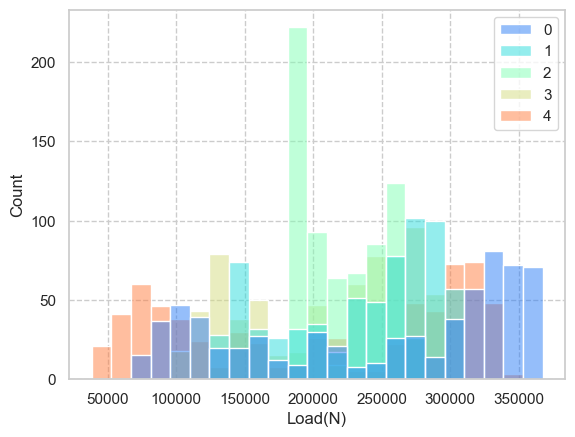

In [12]:
file_name_index = 0
file_name = os.path.basename(train_data_file_path_list[file_name_index])

sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.histplot(raw_train_dataset[file_name][:, 3:8], palette='rainbow')
plt.xlabel('Load(N)')

Text(0.5, 0, 'Load(N)')

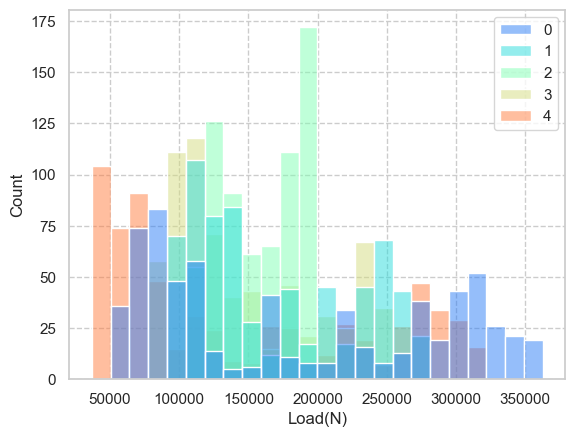

In [13]:
#plt.xlim(-100, 200)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.histplot(raw_train_dataset[file_name][:, 8:13], palette='rainbow')
plt.xlabel('Load(N)')

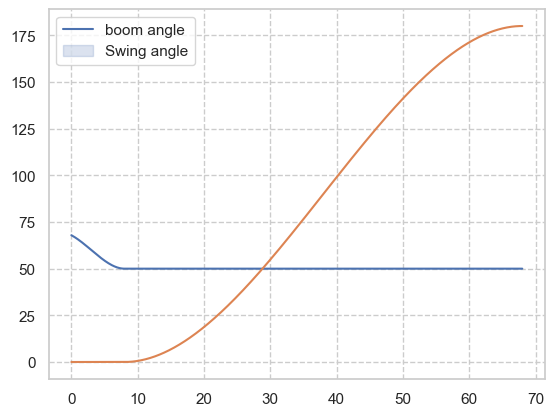

In [14]:
file_name_index = 0
file_name = os.path.basename(val_data_file_path_list[file_name_index])
time_arr = np.arange(0, (raw_val_dataset[file_name].shape[file_name_index])*0.1, 0.1)
sns.set_style("whitegrid", {'grid.linestyle': '--'})

for i in range(2):
    sns.lineplot(x=time_arr, y=raw_val_dataset[file_name][:, i])

plt.legend(['boom angle', 'Swing angle'])

Text(0.5, 0, 'Load(N)')

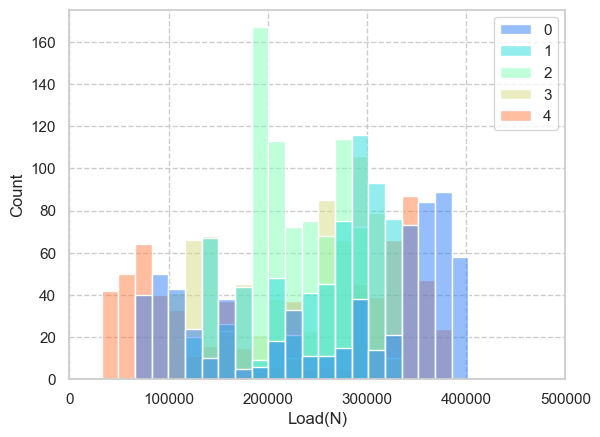

In [15]:
file_name_index = 0
file_name = os.path.basename(val_data_file_path_list[file_name_index])

sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.histplot(raw_val_dataset[file_name][:, 3:8], palette='rainbow')
plt.xlim(0, 500000)
plt.xlabel('Load(N)')

Text(0.5, 0, 'Load(N)')

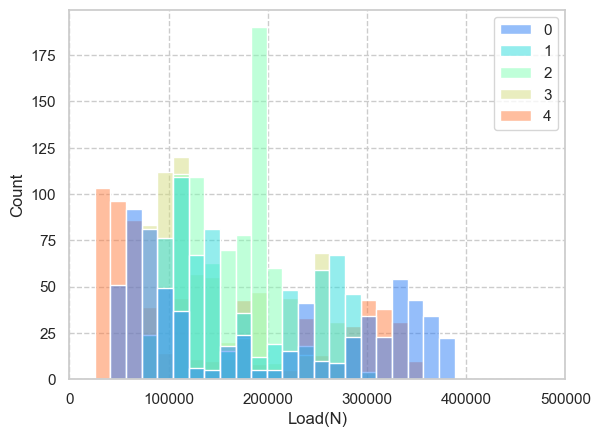

In [16]:
file_name_index = 0
file_name = os.path.basename(val_data_file_path_list[file_name_index])

sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.histplot(raw_val_dataset[file_name][:, 8:13], palette='rainbow')
plt.xlim(0, 500000)
plt.xlabel('Load(N)')

#### execute feature engineering

In [17]:
new_train_dataset = dict()

for file_path in train_data_file_path_list:
    file_name = os.path.basename(file_path)
    new_train_dataset[file_name] = np.copy(raw_train_dataset[file_name])
    
    train_grad_boom_angle = np.gradient(new_train_dataset[file_name][:, 0])
    train_grad_swing_angle = np.gradient(new_train_dataset[file_name][:, 1])
    
    train_grad_load_list = []
    
    for i in range(10):
        train_grad_load_list.append(np.gradient(new_train_dataset[file_name][:, 3+i]))
    
    train_grad_angle = np.stack([train_grad_boom_angle, train_grad_swing_angle], axis=1)
    train_grad_load = np.array(train_grad_load_list).T

    new_train_dataset[file_name] = np.hstack([new_train_dataset[file_name][:, 0:3], train_grad_angle, train_grad_load, new_train_dataset[file_name][:, 3:13]]) 

# new data columns: 0:boom angle, 1:swing angle, 2:operation load, 3:grad_boom_angle, 4:grad_swing_angle, 5~14:grad_load(10ea), 15~24: ground load(10ea) 

In [18]:
new_val_dataset = dict()

for file_path in val_data_file_path_list:
    file_name = os.path.basename(file_path)
    new_val_dataset[file_name] = np.copy(raw_val_dataset[file_name])
    
    val_grad_boom_angle = np.gradient(new_val_dataset[file_name][:, 0])
    val_grad_swing_angle = np.gradient(new_val_dataset[file_name][:, 1])
    
    val_grad_load_list = []
    
    for i in range(10):
        val_grad_load_list.append(np.gradient(new_val_dataset[file_name][:, 3+i]))
    
    val_grad_angle = np.stack([val_grad_boom_angle, val_grad_swing_angle], axis=1)
    val_grad_load = np.array(val_grad_load_list).T

    new_val_dataset[file_name] = np.hstack([new_val_dataset[file_name][:, 0:3], val_grad_angle, val_grad_load, new_val_dataset[file_name][:, 3:13]]) 

<AxesSubplot:>

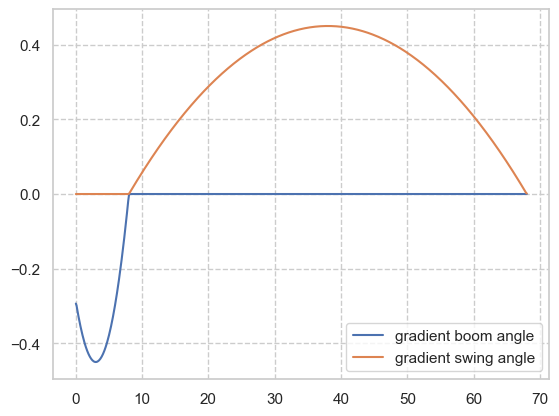

In [19]:
file_name_index = 0
file_name = os.path.basename(train_data_file_path_list[file_name_index])
time_arr = np.arange(0, (new_train_dataset[file_name].shape[0])*0.1, 0.1)

sns.set_style("whitegrid", {'grid.linestyle': '--'})
#sns.scatterplot(x=time_arr, y=new_train_dataset[file_name][:, 0], label='boom angle')
sns.lineplot(x=time_arr, y=new_train_dataset[file_name][:, 3], label='gradient boom angle')
sns.lineplot(x=time_arr, y=new_train_dataset[file_name][:, 4], label='gradient swing angle')
#plt.ylim(-3, 3)

(-1.0, 1.0)

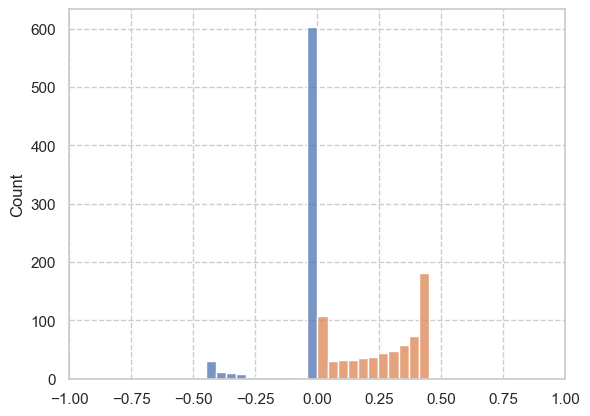

In [20]:
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.histplot(new_train_dataset[file_name][:, 3], label='gradient boom angle')
sns.histplot(new_train_dataset[file_name][:, 4], label='gradient swing angle')
plt.xlim(-1, 1)


<AxesSubplot:>

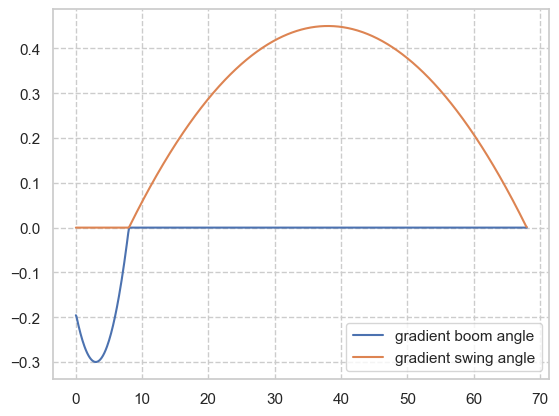

In [21]:
file_name_index = 0
file_name = os.path.basename(val_data_file_path_list[file_name_index])
time_arr = np.arange(0, (new_val_dataset[file_name].shape[0])*0.1, 0.1)

sns.set_style("whitegrid", {'grid.linestyle': '--'})
#sns.scatterplot(x=time_arr, y=new_train_dataset[file_name][:, 0], label='boom angle')
sns.lineplot(x=time_arr, y=new_val_dataset[file_name][:, 3], label='gradient boom angle')
sns.lineplot(x=time_arr, y=new_val_dataset[file_name][:, 4], label='gradient swing angle')

(-6000.0, 6000.0)

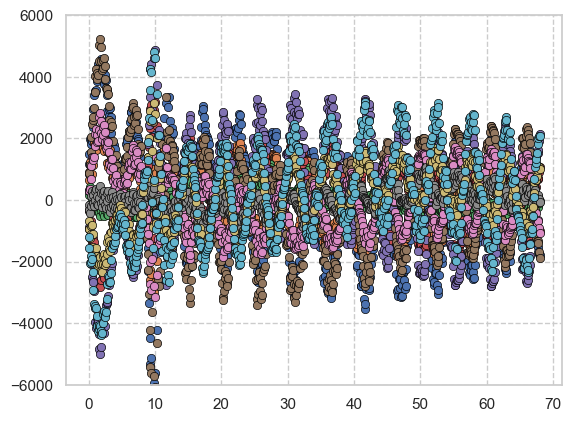

In [22]:
file_name_index = 0
file_name = os.path.basename(train_data_file_path_list[file_name_index])
time_arr = np.arange(0, (new_train_dataset[file_name].shape[0])*0.1, 0.1)

sns.set_style("whitegrid", {'grid.linestyle': '--'})

for i in range(10):
    sns.scatterplot(x=time_arr, y=new_train_dataset[file_name][:, 5+i], edgecolor='black')

plt.ylim(-6000, 6000)

(-6000.0, 6000.0)

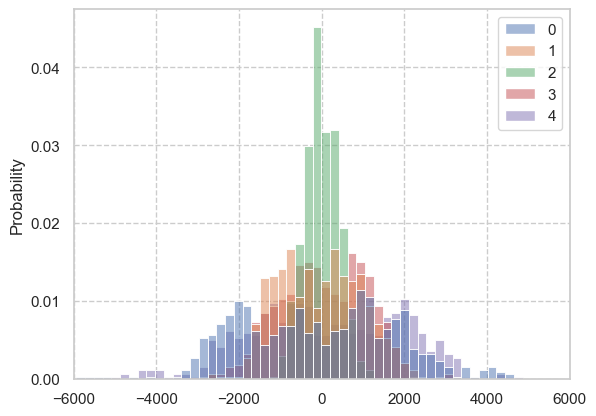

In [23]:
file_name_index = 0
file_name = os.path.basename(train_data_file_path_list[file_name_index])
time_arr = np.arange(0, (new_train_dataset[file_name].shape[0])*0.1, 0.1)

sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.histplot(new_train_dataset[file_name][:, 5:10], stat='probability')
plt.xlim(-6000, 6000)

(-6000.0, 6000.0)

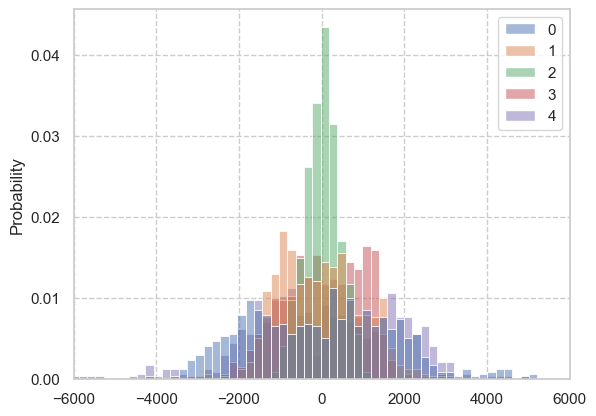

In [24]:
file_name_index = 0
file_name = os.path.basename(train_data_file_path_list[file_name_index])
time_arr = np.arange(0, (new_train_dataset[file_name].shape[0])*0.1, 0.1)

sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.histplot(new_train_dataset[file_name][:, 10:15], stat='probability')
plt.xlim(-6000, 6000)

#### data merge from feature extraction

In [25]:
arr_list = []

for file_path in train_data_file_path_list:
    file_name = os.path.basename(file_path)
    arr_list.append(new_train_dataset[file_name])

new_train_total_data = np.vstack(arr_list)

In [26]:
scaler = RobustScaler().fit(new_train_total_data)

In [27]:
scaled_new_train_dataset = dict()
scaled_new_val_dataset = dict()

for file_path in train_data_file_path_list:
    file_name = os.path.basename(file_path)
    scaled_new_train_dataset[file_name] = scaler.transform(new_train_dataset[file_name])

for file_path in val_data_file_path_list:
    file_name = os.path.basename(file_path)
    scaled_new_val_dataset[file_name] = scaler.transform(new_val_dataset[file_name])

(0.0, 20.0)

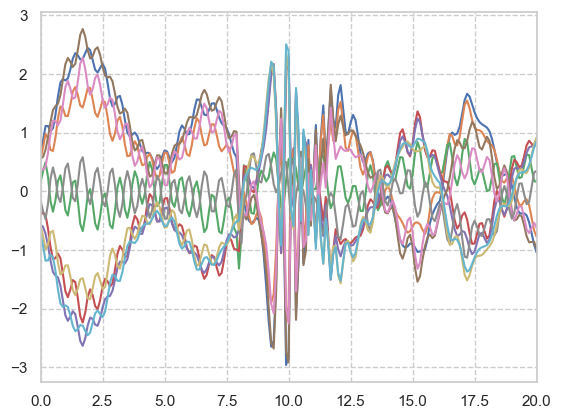

In [28]:
file_name_index = 0
file_name = os.path.basename(train_data_file_path_list[file_name_index])
time_arr = np.arange(0, (new_train_dataset[file_name].shape[0])*0.1, 0.1)

for i in range(10):
    sns.lineplot(x=time_arr, y=scaled_new_train_dataset[file_name][:, i+5])

plt.xlim(0, 20)

<AxesSubplot:>

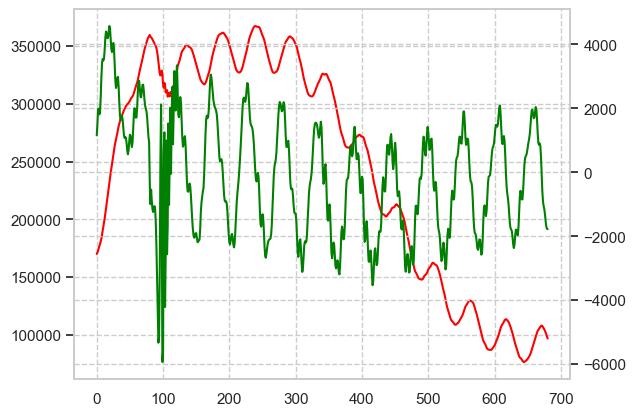

In [29]:
fig, axe1 = plt.subplots()
axe2 = axe1.twinx()

grad_raw_data = new_train_dataset[train_data_file_name_list[0]][:, 15]
sns.lineplot(grad_raw_data, ax=axe1, color='red')

grad_data = new_train_dataset[train_data_file_name_list[0]][:, 5]
sns.lineplot(grad_data, ax=axe2, color='green')

0.42508653053556217


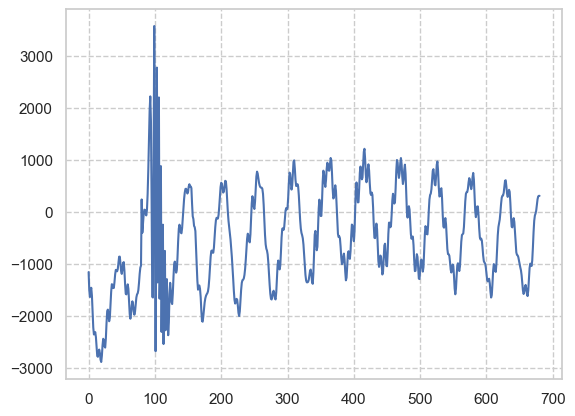

In [30]:
reconst_data = grad_raw_data[0]+np.cumsum(grad_data)

sns.lineplot(grad_raw_data-reconst_data)
print(np.mean((abs(grad_raw_data-reconst_data)/grad_raw_data)*100))

<AxesSubplot:>

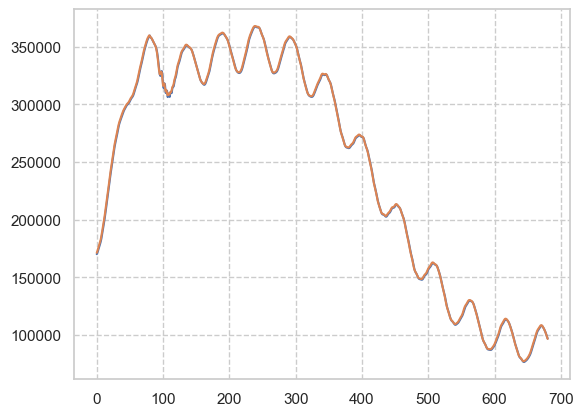

In [31]:
sns.lineplot(grad_raw_data)
sns.lineplot(reconst_data)

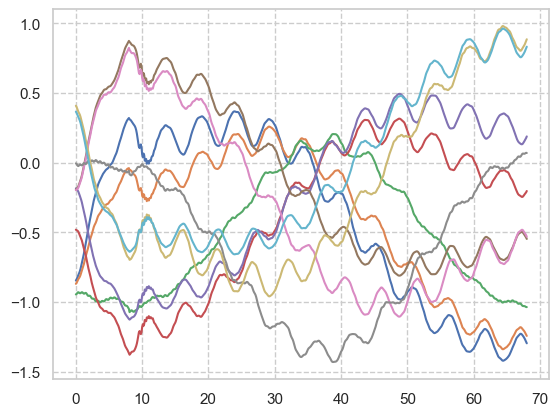

In [32]:
file_name_index = 0
file_name = os.path.basename(train_data_file_path_list[file_name_index])
time_arr = np.arange(0, (scaled_new_train_dataset[file_name].shape[0])*0.1, 0.1)

for i in range(10):
    sns.lineplot(x=time_arr, y=scaled_new_train_dataset[file_name][:, i+15])

<AxesSubplot:ylabel='Count'>

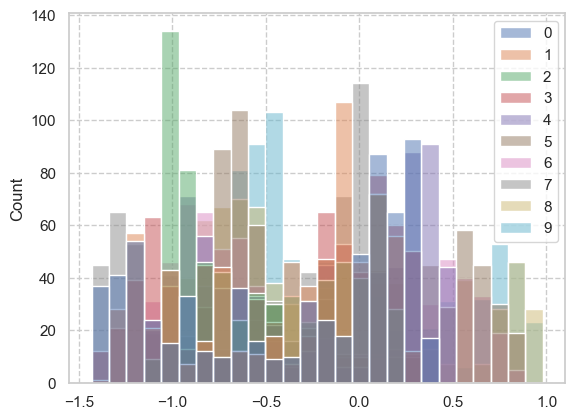

In [33]:
file_name_index = 0
file_name = os.path.basename(train_data_file_path_list[file_name_index])

sns.histplot(scaled_new_train_dataset[file_name][: , 15:])

In [34]:
def create_dataset(data, seq_len=1, pred_distance=1, target_idx_pos=1):
    feature, target = [], []
    
    for i in range(data.shape[0] - pred_distance):
        if i+1 >= seq_len:
            feature.append(data[i+1-seq_len:i+1, 0:15])
            target.append(data[i+pred_distance, target_idx_pos])
    
    return np.array(feature), np.array(target)

In [35]:
seq_len = 30
pred_distance = 20
n_feature = 15
n_of_output = 1
hidden_size = 1000

In [36]:
data_len_list = []

for file_path in train_data_file_path_list:
    file_name = os.path.basename(file_path)
    
    data_len_list.append(scaled_new_train_dataset[file_name].shape[0])

batch_size = max(data_len_list)

In [37]:
def my_lstm():
    input_layer = keras.layers.Input(shape=(seq_len, n_feature))
    conv_layer = keras.layers.Conv1D(filters=n_feature*10, kernel_size=15, padding='valid', activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))(input_layer)
    conv_layer = keras.layers.Conv1D(filters=n_feature*10, kernel_size=9, padding='valid', activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))(conv_layer)
    conv_layer = keras.layers.Conv1D(filters=n_feature*10*5, kernel_size=7, padding='valid', activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))(conv_layer)
    #conv_layer = keras.layers.MaxPool1D(pool_size=2)(conv_layer)

    # lstm_layers = []
    # weight_set ={}
    # 
    # for i in range(n_of_output):
    #     #lstm_input = keras.layers.MaxPooling1D(pool_size=2)(lstm_input)
    #     lstm_output = keras.layers.LSTM(units=hidden_size, return_sequences=False, kernel_regularizer=keras.regularizers.l2(0.01), dropout=0.2, name=f'lstm_{i}')(conv_layer)
    #     #lstm_output = Dense(1, activation='linear')(lstm_output)
    #     lstm_layers.append(lstm_output)
    # 
    # concat = keras.layers.concatenate(lstm_layers)
    
    lstm_output = keras.layers.LSTM(units=hidden_size, return_sequences=False, kernel_regularizer=keras.regularizers.l2(0.01), dropout=0.2, name=f'lstm_{i}')(conv_layer)
    output_layer = keras.layers.Dense(n_of_output, activation='linear')(lstm_output)

    model = keras.Model(inputs=input_layer, outputs=output_layer)

    model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['mean_absolute_error', 'mean_absolute_percentage_error'])
    
    return model  

In [38]:
model_set = dict()

for i in range(10):
    model_set['lstm_'+str(i)] = my_lstm()

model_set['lstm_0'].summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 15)]          0         
                                                                 
 conv1d (Conv1D)             (None, 16, 150)           33900     
                                                                 
 conv1d_1 (Conv1D)           (None, 8, 150)            202650    
                                                                 
 conv1d_2 (Conv1D)           (None, 2, 750)            788250    
                                                                 
 lstm_0 (LSTM)               (None, 1000)              7004000   
                                                                 
 dense (Dense)               (None, 1)                 1001      
                                                                 
Total params: 8,029,801
Trainable params: 8,029,801
Non-train

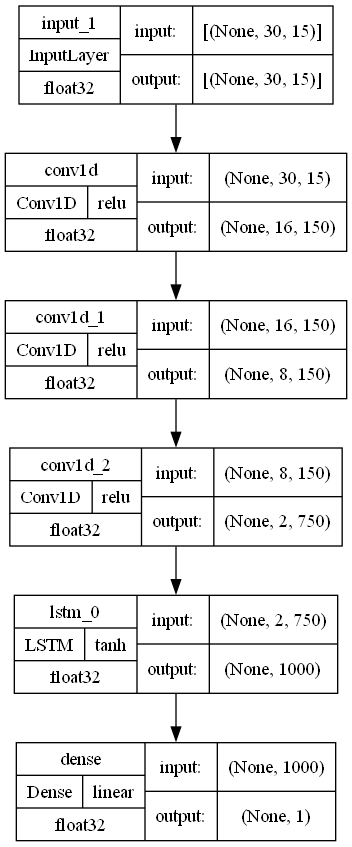

In [39]:
keras.utils.plot_model(model_set['lstm_0'], to_file='model.png', show_shapes=True, show_layer_names=True, show_layer_activations=True, show_dtype=True)

In [40]:
new_train_dataset_arr = []

for file_name in train_data_file_name_list: 
    new_train_dataset_arr.append(scaled_new_train_dataset[file_name])

new_train_dataset_arr = np.vstack(new_train_dataset_arr)


new_val_dataset_arr = []

for file_name in val_data_file_name_list:
    new_val_dataset_arr.append(scaled_new_val_dataset[file_name])

new_val_dataset_arr = np.vstack(new_val_dataset_arr)

In [41]:
model_history_set = list()

for i in range(len(model_set)):
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=300, verbose=1)
    csv_logger = keras.callbacks.CSVLogger('log.csv', append=True, separator=',')
    model_chk_point = keras.callbacks.ModelCheckpoint(filepath=os.path.join('models', f'model_{i}.keras'), monitor="val_loss", verbose=0, save_best_only=True,
                                                      save_weights_only=False, mode="min", save_freq="epoch", initial_value_threshold=None)
    print(f'lstm model {i} training...')
    
    x_train, y_train = create_dataset(data=new_train_dataset_arr, seq_len=seq_len, pred_distance=pred_distance, target_idx_pos=i+15)
    x_val, y_val = create_dataset(data=new_val_dataset_arr, seq_len=seq_len, pred_distance=pred_distance, target_idx_pos=i+15)
    
    t0 = time.time()     
    model_history_set.append(model_set[f'lstm_{i}'].fit(x=x_train, y=y_train, validation_data=(x_val, y_val), epochs=100000, batch_size=10000, verbose=0,
                                                        callbacks=[early_stop, csv_logger, model_chk_point]))
    
    epoch = max(model_history_set[i].epoch)
    print(f'lstm model {i} train finished at epoch: {epoch}, elapsed time: {time.time() - t0:.2f} seconds')

lstm model 0 training...
Epoch 769: early stopping
lstm model 0 train finished at epoch: 768, elapsed time: 57.57 seconds
lstm model 1 training...
Epoch 685: early stopping
lstm model 1 train finished at epoch: 684, elapsed time: 53.48 seconds
lstm model 2 training...
Epoch 751: early stopping
lstm model 2 train finished at epoch: 750, elapsed time: 54.16 seconds
lstm model 3 training...
Epoch 1112: early stopping
lstm model 3 train finished at epoch: 1111, elapsed time: 73.10 seconds
lstm model 4 training...
Epoch 1024: early stopping
lstm model 4 train finished at epoch: 1023, elapsed time: 72.46 seconds
lstm model 5 training...
Epoch 1792: early stopping
lstm model 5 train finished at epoch: 1791, elapsed time: 117.12 seconds
lstm model 6 training...
Epoch 990: early stopping
lstm model 6 train finished at epoch: 989, elapsed time: 67.50 seconds
lstm model 7 training...
Epoch 1186: early stopping
lstm model 7 train finished at epoch: 1185, elapsed time: 81.41 seconds
lstm model 8 tr

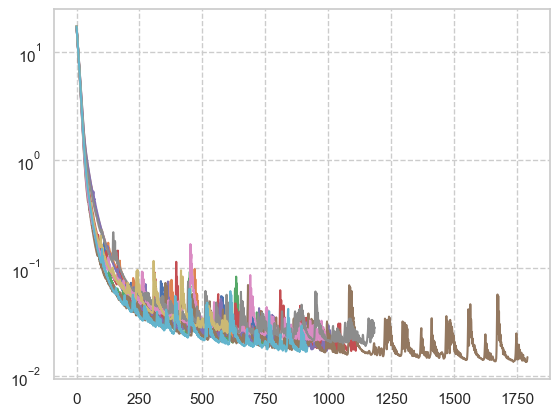

In [45]:
loss_list = []
for model_history in model_history_set:
    loss_list.append(model_history.history['loss'])
    sns.lineplot(model_history.history['loss'])
    
plt.yscale('log')

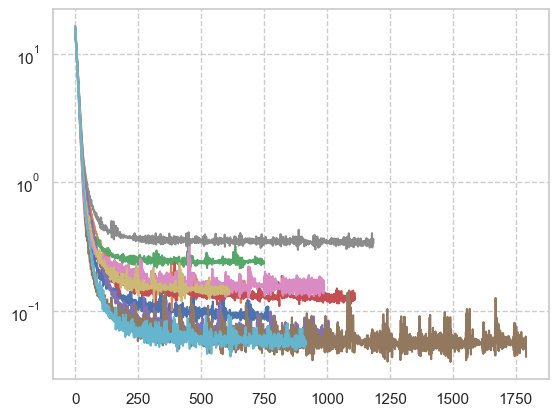

In [46]:
for model_history in model_history_set:
    sns.lineplot(model_history.history['val_loss'])

plt.yscale('log')

In [48]:
best_model_set = dict()

for i in tqdm(range(len(model_set)), desc='Loading best models'):
    best_model_set[f'lstm_{i}'] = keras.models.load_model(os.path.join('models', f'model_{i}.keras'))

Loading best models:   0%|          | 0/10 [00:00<?, ?it/s]

In [62]:
total_train_r2_score = []
total_train_mae = []
total_train_relative_err = []

total_val_r2_score = []
total_val_mae = []
total_val_relative_err = []

train_target_list = []
train_pred_target_list = []

val_target_list = []
val_pred_target_list = []

for i in range(len(best_model_set)):
    x_train, y_train = create_dataset(data=new_train_dataset_arr, seq_len=seq_len, pred_distance=pred_distance, target_idx_pos=i+15)
    x_val, y_val = create_dataset(data=new_val_dataset_arr, seq_len=seq_len, pred_distance=pred_distance, target_idx_pos=i+15)
                    
    train_pred = best_model_set[f'lstm_{i}'].predict(x_train)
    val_pred = best_model_set[f'lstm_{i}'].predict(x_val)

    train_pred = np.squeeze(train_pred)
    val_pred = np.squeeze(val_pred)
    
    a1 = y_train.reshape(-1, 1)
    a2 = train_pred.reshape(-1, 1)

    b1 = y_val.reshape(-1, 1)
    b2 = val_pred.reshape(-1, 1)

    a_a = np.hstack([a1, np.zeros(shape=(y_train.shape[0], 9))])
    a_b = np.hstack([a2, np.zeros(shape=(train_pred.shape[0], 9))])

    b_a = np.hstack([b1, np.zeros(shape=(y_val.shape[0], 9))])
    b_b = np.hstack([b2, np.zeros(shape=(val_pred.shape[0], 9))])
    
    y_train = scaler.inverse_transform(np.hstack([np.zeros(shape=(y_train.shape[0], n_feature)), a_a]))
    y_train = y_train[:, 15]

    y_train_pred = scaler.inverse_transform(np.hstack([np.zeros(shape=(train_pred.shape[0], n_feature)), a_b]))
    y_train_pred = y_train_pred[:, 15]


    y_val = scaler.inverse_transform(np.hstack([np.zeros(shape=(y_val.shape[0], n_feature)), b_a]))
    y_val = y_val[:, 15]

    y_val_pred = scaler.inverse_transform(np.hstack([np.zeros(shape=(val_pred.shape[0], n_feature)), b_b]))
    y_val_pred = y_val_pred[:, 15]
    
    train_target_list.append(y_train)
    train_pred_target_list.append(y_train_pred)
    val_target_list.append(y_val)
    val_pred_target_list.append(y_val_pred)
    
    total_train_r2_score.append(r2_score(y_train, y_train_pred))
    total_train_mae.append(mean_absolute_error(y_train, y_train_pred))
    total_train_relative_err.append(np.mean((abs(y_train-y_train_pred)/y_train)*100))
    
    total_val_r2_score.append(r2_score(y_val, y_val_pred))
    total_val_mae.append(mean_absolute_error(y_val, y_val_pred))
    total_val_relative_err.append(np.mean((abs(y_val-y_val_pred)/y_val)*100))

40/40 [==============================] - 0s 2ms/step


In [63]:
print(np.mean(total_train_r2_score), np.mean(total_train_mae), np.mean(total_train_relative_err))
print(np.mean(total_val_r2_score), np.mean(total_val_mae), np.mean(total_val_relative_err))

0.9390971818769247 20103.565955363716 7.628106369498492
0.750294574942582 28219.620466784505 14.413525136695998


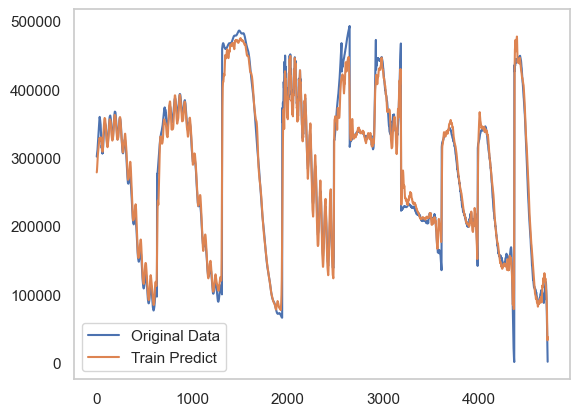

In [69]:
load_idx = 0
sns.lineplot(train_target_list[load_idx], label='Original Data')
sns.lineplot(train_pred_target_list[load_idx], label='Train Predict')
#plt.xlim(2000, 3000)
plt.grid()
plt.legend()
plt.show()

In [ ]:
#dtw_path = dtw.warping_path(y_train[:, 0], y_train_pred[:, 0])
#dtwvis.plot_warping(y_train[:, 0], y_train_pred[:, 0], dtw_path)

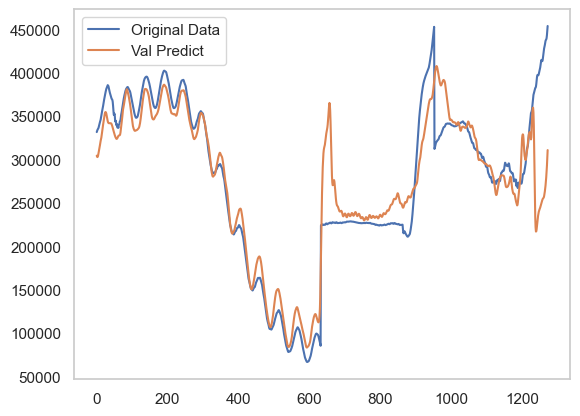

In [80]:
load_idx = 0
sns.lineplot(val_target_list[load_idx], label='Original Data')
sns.lineplot(val_pred_target_list[load_idx], label='Val Predict')
#plt.xlim(2000, 3000)
plt.grid()
plt.legend()
plt.show()

In [ ]:
#dtw_path = dtw.warping_path(y_val[:, 0], y_val_pred[:, 0])
#dtwvis.plot_warping(y_val[:, 0], y_val_pred[:, 0], dtw_path)

In [ ]:
sns.set(font_scale=1.0)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')

metric_log_arr = np.vstack(metric_log)
train_loss_arr = metric_log_arr[:, 1]
val_loss_arr = metric_log_arr[:, 2]
epoch_arr = metric_log_arr[:, 0]+1

sns.lineplot(x=epoch_arr, y=train_loss_arr, label='Train Loss')
sns.lineplot(x=epoch_arr, y=val_loss_arr, label='Validation Loss')

In [ ]:
sns.set(font_scale=1.0)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
plt.xlabel('Epoch')
plt.ylabel('Mean Error(N)')

epoch_arr = metric_log_arr[:, 0]+1
train_abs_error_arr = metric_log_arr[:, 3]
val_abs_error_arr = metric_log_arr[:, 4]

sns.lineplot(x=epoch_arr, y=train_abs_error_arr, label='Train Mean Absolute Error')
sns.lineplot(x=epoch_arr, y=val_abs_error_arr, label='Validation Mean Absolute Error')
plt.yscale('log')

In [ ]:
spec = (tf.TensorSpec(best_model_set['lstm_0'].inputs[0].shape, tf.float32, name='input'), )
onnx_model_set = []

for i in range(len(best_model_set)):
    onnx_model, _ = tf2onnx.convert.from_keras(best_model_set[f'lstm_{i}'], input_signature=spec)
    onnx_model_set.append(onnx_model)


In [ ]:


with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())